In [1]:
import torch
import random
import subprocess
import numpy as np
from tqdm import tqdm
from scipy import stats
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse
import pandas as pd
import seaborn as sns
import matplotlib
import os

In [2]:
def replace_conditions(adata):
    adata.obs["condition"].replace("CD4T_ctrl", "CD4-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD4T_real_stim", "CD4-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD4T_pred_stim", "CD4-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD8T_ctrl", "CD8-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD8T_real_stim", "CD8-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD8T_pred_stim", "CD8-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("Dendritic_ctrl", "DC_ctrl", inplace=True)
    adata.obs["condition"].replace("Dendritic_real_stim", "DC_real_stim", inplace=True)
    adata.obs["condition"].replace("Dendritic_pred_stim", "DC_pred_stim", inplace=True)

    adata.obs["condition"].replace("FCGR3A+Mono_ctrl", "F-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_real_stim", "F-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_pred_stim", "F-Mono_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD14+Mono_ctrl", "CD14-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_real_stim", "CD14-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_pred_stim", "CD14-Mono_pred_stim", inplace=True)
def replace_cell_types(adata):
    adata.obs["cell_type"].replace("CD4T", "CD4-T", inplace=True)
    adata.obs["cell_type"].replace("CD8T", "CD8-T", inplace=True)
    adata.obs["cell_type"].replace("Dendritic", "DC", inplace=True)
    adata.obs["cell_type"].replace("FCGR3A+Mono", "F-Mono", inplace=True)
    adata.obs["cell_type"].replace("CD14+Mono", "CD14-Mono", inplace=True)

In [3]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=18)

In [4]:
def adata2numpy(adata):
    if sparse.issparse(adata.X):
        return adata.X.A
    else:
        return adata.X

In [5]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=False, legend=False, offset=0.375):
    plt.close("all")
#     import matplotlib
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=30)
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
    plt.figure(figsize=(12, 10))
#     g = sns.catplot(x=cat, y=val, hue=subcat, data=df, kind='bar', palette="muted", height=6, legend=False)
#     g.despine(left=True)
#     plt.yticks(np.arange(0, 1.2, 0.2))
#     g.set_xticklabels(rotation=90)
#     g.set_xlabels("")
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values)
        a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
#         print(a.shape)
#         dfc=pd.DataFrame({'x': x_pos + i/1.25, 'y': a[0]})
        plt.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=25)
    plt.xticks(x_pos+offset, u, rotation=90)
    if legend:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join('figures', filename), dpi=300)
    plt.show()

In [6]:
def calc_R2_specific_model(adata, n_genes, conditions):
    if n_genes != adata.shape[1]:
        sc.tl.rank_genes_groups(adata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = adata.uns["rank_genes_groups"]["names"][conditions["real_stim"]]
        adata = adata[:, diff_genes.tolist()]
    r2_means, r2_vars = [], []
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
    pred_stim = adata2numpy(pred_stim)
    real_stim = adata2numpy(real_stim)
    for i in range(100):
        pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.8 * pred_stim.shape[0]))
        real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.8 * real_stim.shape[0]))
        x = np.average(pred_stim[pred_stim_idx], axis=0)
        y = np.average(real_stim[real_stim_idx], axis=0)
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        r_values[0, i] = r_value ** 2
    print(r_values.mean(), r_values.std())
    return r_values.mean(), r_values.std()

In [7]:
name_pbmc = ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK']

In [8]:
STGAN_CD4T = sc.read("data/stgan_cd4t.h5ad")
CVAE_CD4T = sc.read("data/CVAE_CD4T.h5ad")
WGAN_CD4T = sc.read("data/result_WGAN_redo.h5ad")
SCGEN_CD4T = sc.read("data/supervised_scgen_CD4T_result.h5ad")
ours_CD4T = sc.read("data/one_loss_spaperb_CD4T_result.h5ad")
pbmc = sc.read("data/valid_pbmc.h5ad")
CD4T = pbmc[pbmc.obs['cell_type'] == 'CD4T']
stim_CD4T = CD4T[CD4T.obs["condition"] == "stimulated"]
WGAN_CD4T = WGAN_CD4T.concatenate(stim_CD4T)
WGAN_CD4T.obs['condition']
CVAE_CD4T = CVAE_CD4T[CVAE_CD4T.obs['condition'] == 'pred']
CVAE_CD4T = CVAE_CD4T.concatenate(stim_CD4T)
# replace_conditions(CGAN_CD4T)
# replace_conditions(CVAE_CD4T)
# replace_conditions(WGAN_CD4T)
# replace_conditions(SCGEN_CD4T)
# replace_conditions(ours_CD4T)
# replace_conditions(CD4T)
# CGAN_CD4T.obs['condition']
# ours_CD4T.obs['condition']

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [9]:
ctrl_CD4T = CD4T[CD4T.obs["condition"] == "control"]
stim_CD4T = CD4T[CD4T.obs["condition"] == "stimulated"]
STGAN_CD4T_stim = STGAN_CD4T[STGAN_CD4T.obs["condition"] == "pred_stim"]
CVAE_CD4T_stim = CVAE_CD4T[CVAE_CD4T.obs["condition"] == "pred"]
WGAN_CD4T_stim = WGAN_CD4T[WGAN_CD4T.obs["condition"] == "pred"]
SCGEN_CD4T_stim = SCGEN_CD4T[SCGEN_CD4T.obs["condition"] == "pred"]
ours_CD4T_stim = ours_CD4T[ours_CD4T.obs["condition"] == "pred"]
# ctrl_CD4T
# stim_CD4T
# CGAN_CD4T_stim
# CVAE_CD4T_stim
# WGAN_CD4T_stim
# SCGEN_CD4T_stim
# ours_CD4T_stim

In [10]:
ctrl_CD4T.obs["condition"] = "control"
stim_CD4T.obs["condition"] = "stimulation real"
STGAN_CD4T_stim.obs["condition"] = "style transfer GAN"
CVAE_CD4T_stim.obs["condition"] = "CVAE"
WGAN_CD4T_stim.obs["condition"] = "WGAN"
SCGEN_CD4T_stim.obs["condition"] = "SCGEN"
ours_CD4T_stim.obs["condition"] = "Ours"

/home/tony/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.
/home/tony/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  
/home/tony/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tony/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  after removing the cwd from sys.path.
/home/tony/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of 

In [11]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]['stimulated']
diff_genes

/opt/conda/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


array(['ISG15', 'IFI6', 'ISG20', ..., 'FTL', 'RGCC', 'FTH1'], dtype=object)

In [12]:
models = ctrl_CD4T.concatenate(stim_CD4T, ours_CD4T_stim, SCGEN_CD4T_stim, CVAE_CD4T_stim, STGAN_CD4T_stim, WGAN_CD4T_stim)
# models_violin = ctrl_CD4T.concatenate(stim_CD4T, SCGEN_CD4T_stim, CVAE_CD4T_stim, STGAN_CD4T_stim, WGAN_CD4T_stim, ours_CD4T_stim)
models_violin = models

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [13]:
def create_df(adata, data_name):
    adata_test = adata.concatenate(stim_CD4T)
    sc.tl.rank_genes_groups(adata_test, groupby="condition", method="wilcoxon")
    adata_names = np.array(adata_test.uns["rank_genes_groups"]['names'].tolist())
    adata_pval = np.array(adata_test.uns["rank_genes_groups"]['pvals_adj'].tolist())
    ind = []
    for name in adata_names:
        ind.append(name[0])
    pval = []
    for pv in adata_pval:
        pval.append(pv[0])
    
    df = pd.DataFrame(index=ind)
    df[data_name + "_Pval"] = pval
    
    return df

In [14]:
ours_df = create_df(ours_CD4T_stim, "ours")
scgen_df = create_df(SCGEN_CD4T_stim, "scgen")
cvae_df = create_df(CVAE_CD4T_stim, 'cvae')
stgan_df = create_df(STGAN_CD4T_stim, 'stgan')
wgan_df = create_df(WGAN_CD4T_stim, 'wgan')
all_df = ours_df.join([scgen_df, cvae_df, stgan_df, wgan_df], how = 'left')
all_df

/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


,ours_Pval,scgen_Pval,cvae_Pval,stgan_Pval,wgan_Pval
AC002456.2,4.631252e-102,8.952389e-19,1.000000e+00,1.000000e+00,1.845300e-103
SLC2A1,4.631252e-102,3.498560e-90,1.000000e+00,1.000000e+00,1.845300e-103
RP11-656D10.3,4.631252e-102,2.712517e-71,1.000000e+00,1.000000e+00,1.323905e-100
SEMA7A,4.631252e-102,8.775060e-01,1.000000e+00,2.649403e-99,2.665877e-12
AC006129.4,4.631252e-102,1.366944e-22,1.000000e+00,3.759449e-53,1.845300e-103
...,...,...,...,...,...
SOD1,6.220584e-03,1.265692e-01,1.000000e+00,8.840251e-67,1.058922e-61
CCR7,2.581494e-03,8.062478e-07,2.490178e-11,7.199622e-80,1.739804e-51
GIMAP5,7.677658e-04,1.522224e-04,6.939141e-05,2.513248e-95,2.437960e-01
IFIT2,1.006640e-05,7.109822e-02,3.871949e-23,5.937235e-100,1.866463e-05


In [15]:
def plot_violin(use_gene, color_map):
    new_models = models_violin
    var_temp = models_violin.var_names.tolist()
    var_temp[var_temp.index(use_gene)] = use_gene + " in CD4-T"
    new_models.var_names = var_temp
    font = {'family' : 'Arial',
        'size'   : 30}

    sc.set_figure_params(fontsize=25)
    sns.set()
    matplotlib.rc('ytick', labelsize=14)
    matplotlib.rc('xtick', labelsize=14)
    sc.pl.violin(new_models, 
                 keys= use_gene + " in CD4-T", 
                 groupby="condition", 
                 rotation=90,
                 show=True,
                 order=new_models.obs["condition"].unique().tolist(),
                 palette = color_map,
#                  color = "#ee0ef0",
                 save= use_gene + ".pdf"
                )

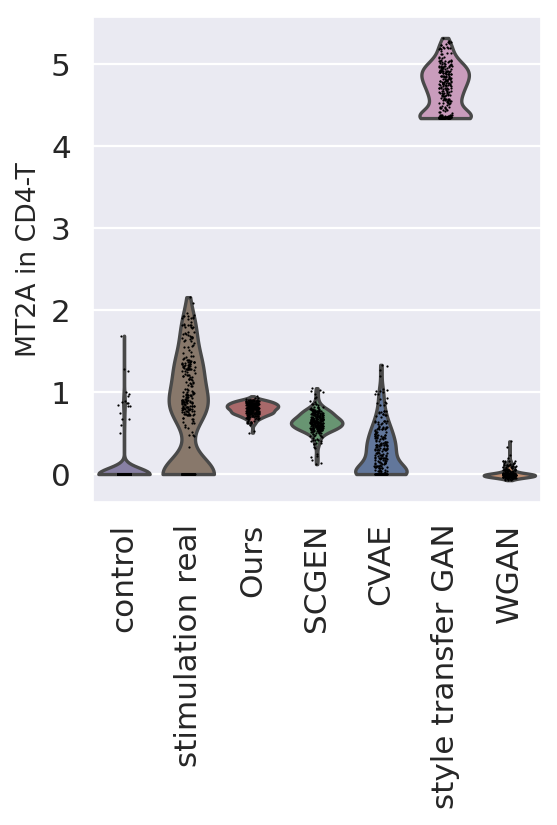

MT2A
ours_Pval      8.785023e-01
scgen_Pval     5.808311e-04
cvae_Pval      9.876309e-11
stgan_Pval    1.164916e-102
wgan_Pval      9.619177e-61
Name: MT2A, dtype: float64


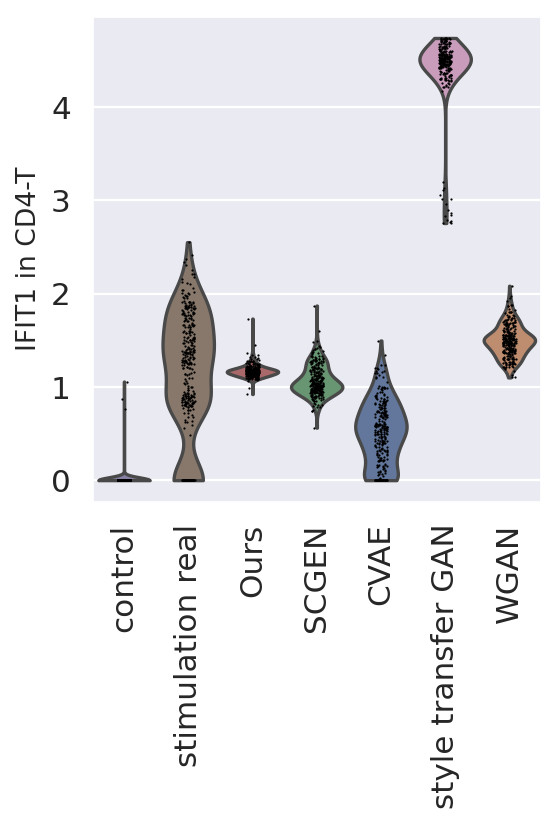

IFIT1
ours_Pval      5.971105e-02
scgen_Pval     2.234554e-03
cvae_Pval      6.331410e-35
stgan_Pval    1.164916e-102
wgan_Pval      4.090767e-12
Name: IFIT1, dtype: float64


In [16]:
# names = ['MT2A', 'S100A11', 'CD3D', 'BTG1', 'UBC', 'PFN1', 'SP100', 'IFIT1']
# sc.pl.StackedViolin.style()
color_map = {'WGAN': '#CB8963', 'Ours': '#B45E60', 'control': '#857AAA', 'SCGEN': '#609D6E', 'CVAE': '#5975A4', 'style transfer GAN': '#D095BF', 'stimulation real': '#8D7866'}
names = ['MT2A', 'IFIT1']
for gene_names in names:    
    plot_violin(gene_names, color_map)
    print(gene_names)
    print(all_df.loc[gene_names])

In [17]:
models.obs['condition'].value_counts()

stimulation real      356
CVAE                  278
Ours                  278
SCGEN                 278
WGAN                  278
control               278
style transfer GAN    278
Name: condition, dtype: int64

In [18]:
STGAN_CD4T.obs['condition']

0           ctrl
1           ctrl
2           ctrl
3           ctrl
4           ctrl
         ...    
907    pred_stim
908    pred_stim
909    pred_stim
910    pred_stim
911    pred_stim
Name: condition, Length: 912, dtype: category
Categories (3, object): ['ctrl', 'pred_stim', 'real_stim']

In [19]:
conditions = {"real_stim": "real_stim", "pred_stim": "pred_stim"}
STGAN_CD4T_mean, STGAN_CD4T_r2_var = calc_R2_specific_model(STGAN_CD4T, n_genes=6998, conditions=conditions)

0.44187737344372235 0.0019928406647996325


In [20]:
conditions = {"real_stim": "stimulated", "pred_stim": "pred"}
CVAE_CD4T_r2_mean, CVAE_CD4T_r2_var = calc_R2_specific_model(CVAE_CD4T, n_genes=6998, conditions=conditions)
WGAN_CD4T_r2_mean, WGAN_CD4T_r2_var = calc_R2_specific_model(WGAN_CD4T, n_genes=6998, conditions=conditions)
SCGEN_CD4T_r2_mean, SCGEN_CD4T_r2_var = calc_R2_specific_model(SCGEN_CD4T, n_genes=6998, conditions=conditions)
ours_CD4T_r2_mean, ours_CD4T_r2_var = calc_R2_specific_model(ours_CD4T, n_genes=6998, conditions=conditions)

0.9176370689962644 0.0028422414918901472
0.06065122560502731 0.0006407750585858263
0.9698351633466682 0.0031249590564978577
0.9905117566494809 0.0007706143331777652


In [21]:
all_means = np.array([ours_CD4T_r2_mean, SCGEN_CD4T_r2_mean, CVAE_CD4T_r2_mean, STGAN_CD4T_mean, WGAN_CD4T_r2_mean])
all_vars = np.array([ours_CD4T_r2_var, SCGEN_CD4T_r2_var, CVAE_CD4T_r2_var, STGAN_CD4T_r2_var, WGAN_CD4T_r2_var])
all_types = ["All genes"] * 5
models = ["ours", "scgen", "CVAE", "Style transfer GAN", "WGAN", ]
df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Models": models})
df

,R^2 Means,R^2 Stddevs,Type,Models
0,0.990512,0.000771,All genes,ours
1,0.969835,0.003125,All genes,scgen
2,0.917637,0.002842,All genes,CVAE
3,0.441877,0.001993,All genes,Style transfer GAN
4,0.060651,0.000641,All genes,WGAN


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


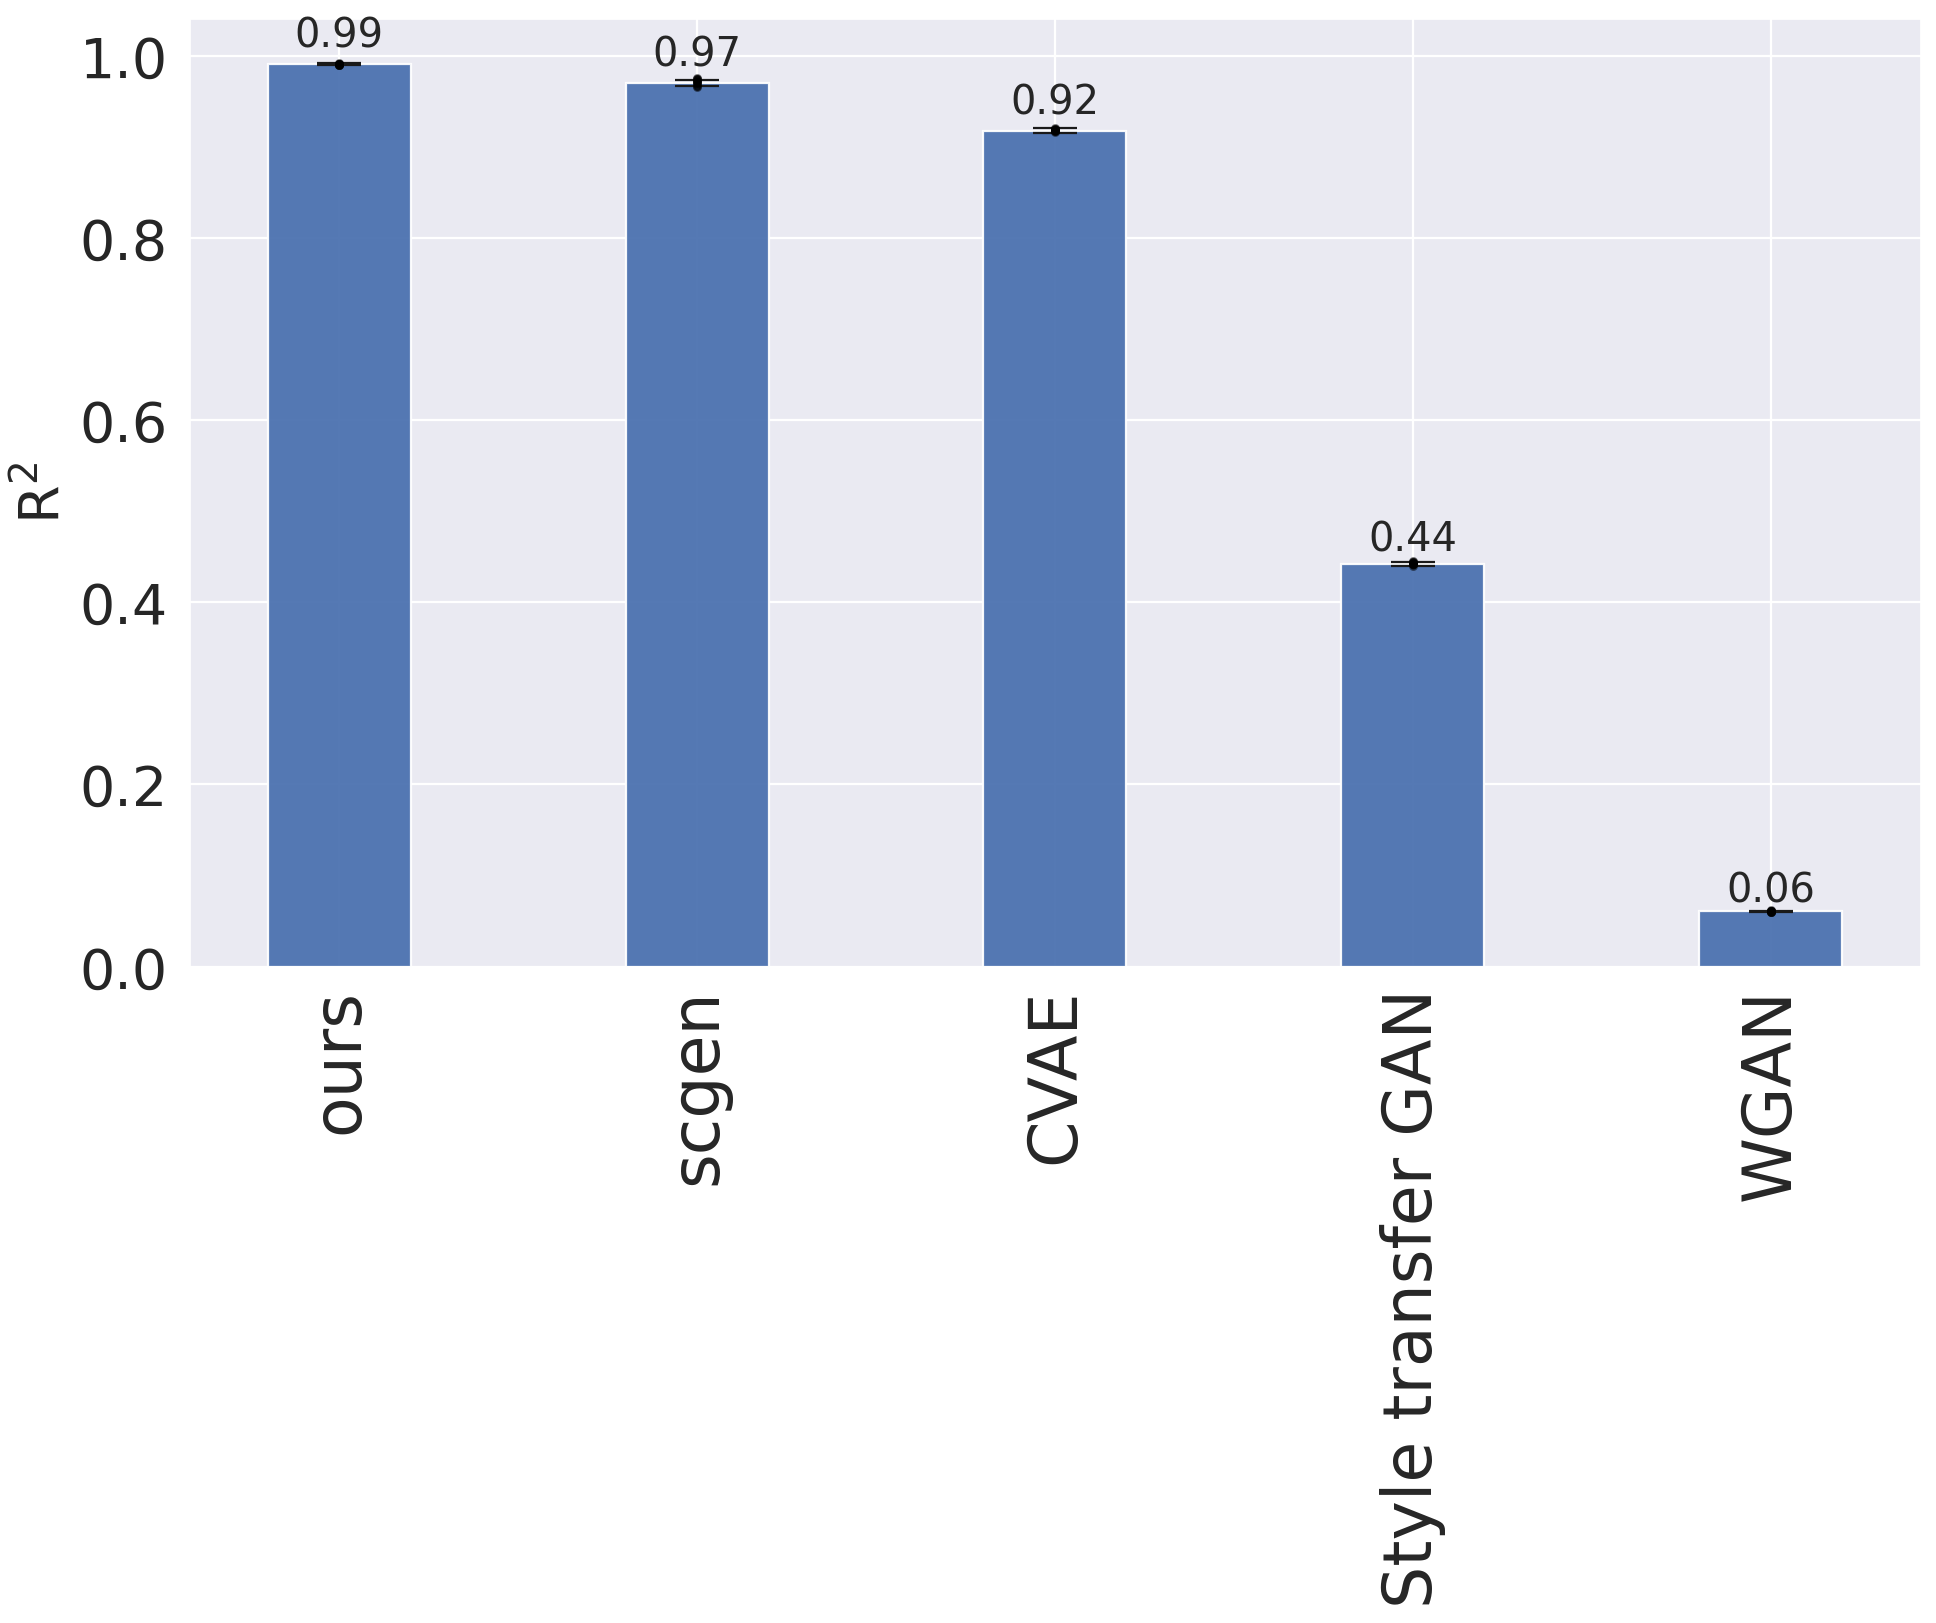

In [22]:
font = {'family' : 'Arial',
        'size'   : 2}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
grouped_barplot(df, "Models", "Type", "R^2 Means", "R^2 Stddevs", put_label=True, legend=False, filename="Fig2e_models_barplots.pdf", offset=0.0)